In [11]:
import pandas as pd
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value, LpStatus

# 1. Read the dataset from an Excel file.
# Change "input.xlsx" to your actual file name.
df = pd.read_excel("input.xlsx")

# 2. Define the columns to be used as inputs and outputs.
# Adjust these lists according to your dataset.
# For example, you might treat volume-type measures as inputs and quality/impact measures as outputs.
input_columns = ["Total Docs", "Total Docs 3y", "Total Refs", "Coverage"]
output_columns = ["SJR-index", "Cite Score", "H-index", "Total Cites 3y", "Citable Docs 3y", "Cites/Doc 2y", "Refs/Doc"]

# If a DMU identifier exists (e.g., "Journal"), we use it; otherwise, we use the dataframe index.
if "Journal" in df.columns:
    dmus = df["Journal"].tolist()
else:
    dmus = df.index.astype(str).tolist()

# Prepare dictionaries for quick access to input and output values.
inputs = {col: df[col].to_dict() for col in input_columns}
outputs = {col: df[col].to_dict() for col in output_columns}

# List of DMU indices (from the DataFrame index)
dmus_index = df.index.tolist()

# Create a list to store the computed efficiency score for each DMU.
efficiency_scores = []

# Loop over each DMU 'o' and solve the DEA CCR model.
# Here we solve an input-oriented DEA model:
#   Minimize theta subject to:
#       sum(lambda_j * x_ij) <= theta * x_io, for each input i
#       sum(lambda_j * y_rj) >= y_ro, for each output r
#       lambda_j >= 0 for all j
for o in dmus_index:
    # Create a new LP for DMU 'o'
    prob = LpProblem(f"DEA_DMU_{o}", LpMinimize)
    
    # Decision variable: theta (efficiency score for DMU 'o')
    # For an input-oriented model, theta is between 0 and 1 (theta=1 means efficient).
    theta = LpVariable("theta", lowBound=0, upBound=1)
    
    # Decision variables: lambda for every DMU in the dataset
    lambda_vars = {j: LpVariable(f"lambda_{j}", lowBound=0) for j in dmus_index}
    
    # Objective: minimize theta.
    prob += theta, "Minimize_theta"
    
    # Input constraints: for each input criterion i,
    # the weighted sum across all DMUs must be <= theta * (input value for DMU 'o').
    for col in input_columns:
        x_io = inputs[col][o]
        # If the DMU 'o' has zero for an input, we skip this constraint.
        if x_io == 0:
            continue
        prob += lpSum(lambda_vars[j] * inputs[col][j] for j in dmus_index) <= theta * x_io, f"Input_{col}_DMU_{o}"
    
    # Output constraints: for each output criterion r,
    # the weighted sum across all DMUs must be >= (output value for DMU 'o').
    for col in output_columns:
        y_ro = outputs[col][o]
        prob += lpSum(lambda_vars[j] * outputs[col][j] for j in dmus_index) >= y_ro, f"Output_{col}_DMU_{o}"
    
    # Solve the LP for DMU 'o'
    prob.solve()
    
    # Retrieve the efficiency score (optimal theta).
    theta_opt = value(theta)
    efficiency_scores.append(theta_opt)
    
    print(f"DMU {dmus[o] if 'Journal' in df.columns else o}: Status = {LpStatus[prob.status]}, Efficiency = {theta_opt:.4f}")

# Create a DataFrame for the output.
output_df = pd.DataFrame({
    "DMU": dmus,
    "Efficiency Score": efficiency_scores
})

# Write the output DataFrame to an Excel file.
output_df.to_excel("output.xlsx", index=False)

print("DEA efficiency evaluation complete. Results saved to 'output.xlsx'.")

DMU 0: Status = Optimal, Efficiency = 1.0000
DMU 1: Status = Optimal, Efficiency = 1.0000
DMU 2: Status = Optimal, Efficiency = 1.0000
DMU 3: Status = Optimal, Efficiency = 1.0000
DMU 4: Status = Optimal, Efficiency = 1.0000
DMU 5: Status = Optimal, Efficiency = 0.9061
DMU 6: Status = Optimal, Efficiency = 1.0000
DMU 7: Status = Optimal, Efficiency = 0.8293
DMU 8: Status = Optimal, Efficiency = 0.6233
DMU 9: Status = Optimal, Efficiency = 1.0000
DMU 10: Status = Optimal, Efficiency = 1.0000
DMU 11: Status = Optimal, Efficiency = 1.0000
DMU 12: Status = Optimal, Efficiency = 0.9906
DMU 13: Status = Optimal, Efficiency = 1.0000
DMU 14: Status = Optimal, Efficiency = 0.7054
DMU 15: Status = Optimal, Efficiency = 0.8723
DMU 16: Status = Optimal, Efficiency = 0.7193
DMU 17: Status = Optimal, Efficiency = 1.0000
DMU 18: Status = Optimal, Efficiency = 0.8317
DMU 19: Status = Optimal, Efficiency = 1.0000
DEA efficiency evaluation complete. Results saved to 'output.xlsx'.


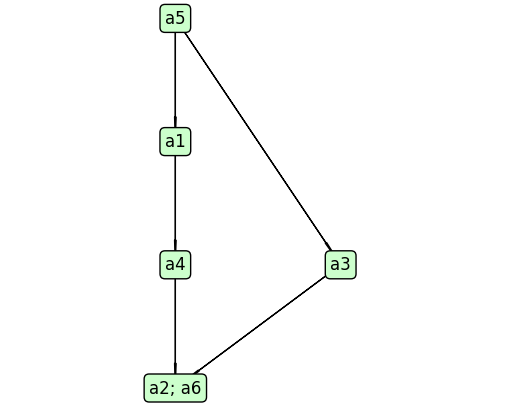




1 a5
2 a1
3 a4
4 a2; a3; a6

1 a5
2 a3
3 a1; a4
4 a2; a6

a1 ['-' 'P+' 'R' 'P+' 'P-' 'P+']
a2 ['P-' '-' 'P-' 'P-' 'P-' 'I']
a3 ['R' 'P+' '-' 'R' 'P-' 'P+']
a4 ['P-' 'P+' 'R' '-' 'P-' 'P+']
a5 ['P+' 'P+' 'P+' 'P+' '-' 'P+']
a6 ['P-' 'I' 'P-' 'P-' 'P-' '-']


In [2]:
import numpy as np
from pyDecision.algorithm import electre_iii

# ELECTRE III

# Parameters
Q = [0.30, 0.30, 0.30, 0.30]
P = [0.50, 0.50, 0.50, 0.50]
V = [0.70, 0.70, 0.70, 0.70]
W = [9.00, 8.24, 5.98, 8.48]

# Dataset
dataset = np.array([
                [8.84, 8.79, 6.43, 6.95],   #a1
                [8.57, 8.51, 5.47, 6.91],   #a2
                [7.76, 7.75, 5.34, 8.76],   #a3
                [7.97, 9.12, 5.93, 8.09],   #a4
                [9.03, 8.97, 8.19, 8.10],   #a5
                [7.41, 7.87, 6.77, 7.23]    #a6
                ])

global_concordance, credibility, rank_D, rank_A, rank_N, rank_P = electre_iii(dataset, P = P, Q = Q, V = V, W = W, graph = True)
print(end='\n')
np.ndarray.round(global_concordance, decimals = 2)
print(end='\n')
np.ndarray.round(credibility, decimals = 2)
print(end='\n')
for i in range(0, len(rank_D)):
  print(str(i+1), rank_D[i])
print(end='\n')
for i in range(0, len(rank_A)):
  print(str(i+1), rank_A[i])
print(end='\n')
for i in range(0, len(rank_P)):
  print('a'+str(i+1), rank_P[i])